In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

In [2]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [3]:
# dataset path
ROOT_DATASET = 'C:\\Users\\Client\\Desktop\\U-Net'
os.listdir(ROOT_DATASET)

['.ipynb_checkpoints',
 'annotations_prepped_test',
 'annotations_prepped_train',
 'gtFine',
 'images_prepped_test',
 'images_prepped_train',
 'Untitled.ipynb']

In [4]:
img_path = ROOT_DATASET + '/images_prepped_train/'
annot_path = ROOT_DATASET + '/annotations_prepped_train/'

In [5]:
import glob

train_images_dir = glob.glob(img_path+'/*.png')
train_annotations_dir = glob.glob(annot_path+'/*.png')

In [6]:
train_images = []
for img in train_images_dir:
    n = cv2.imread(img)
    n = cv2.resize(n, (480,480))
    train_images.append(n)

In [7]:
train_annotations = []
for img in train_annotations_dir:
    n = cv2.imread(img)
    train_annotations.append(n)

In [8]:
def get_colored_segmentation_image(seg, colors,
                                    n_classes):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                             * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                             * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                             * (colors[c][2])).astype('uint8')
    return seg_img

# initiate random colors list (you can change this with your colors list)
# class_colors = [(random.randint(0, 255), random.randint(
#     0, 255), random.randint(0, 255)) for _ in range(5000)]

# initiate fix colors list
class_colors = [(128,0,0), (170,110, 40), (128,128,0), (0,128,128), (0,0,128), (230,25,75), (245,130,48), (255,255,25), (210,245,60), (240,50,230),
               (128,128,128), (220,190,255), (255,215,180), (70,140,240), (0,130,200)]

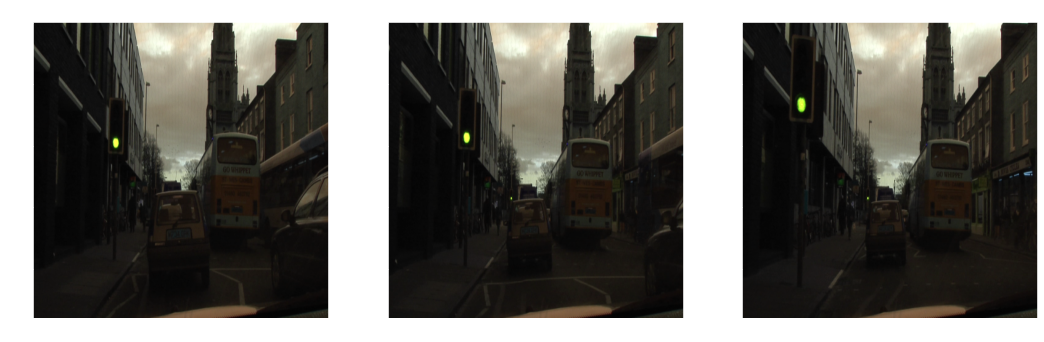

In [9]:
#Plot sample of train images
fig = plt.figure(figsize = (18,10))

for index in range(3):
    ax = fig.add_subplot(1,3,index+1)
    ax.set_title("Sample train image {}".format(index+1))
    ax.imshow(train_images[index], cmap='gray')

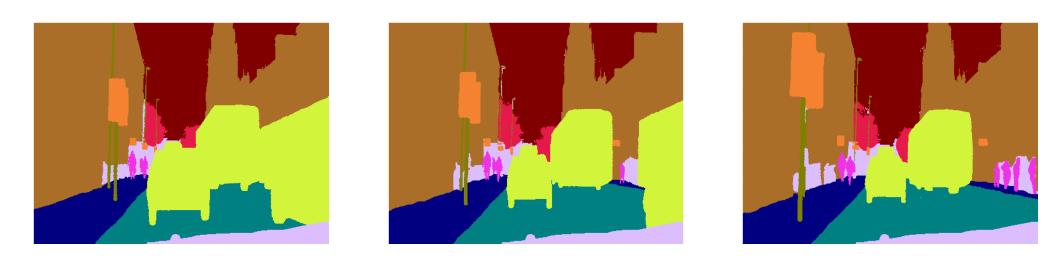

In [10]:
#Plot sample of train annotations
fig = plt.figure(figsize = (18,10))


for index in range(3):
#     image = mpimg.imread(os.path.join(train_annotations_dir, os.listdir(train_annotations_dir)[index]))
    ax = fig.add_subplot(1,3,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    ax.imshow(get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors))

In [11]:
train_annotations = []
for img in train_annotations_dir:
    n = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    n = cv2.resize(n,(480,480))
    train_annotations.append(n)

In [12]:
print("There are {} images in train images".format(len(os.listdir(img_path))))
print("\nThere are {} images in train annotations".format(len(os.listdir(annot_path))))

There are 367 images in train images

There are 367 images in train annotations


In [13]:
print("shape of one sample image in train images dataset: {}".format(train_images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(train_annotations[0].shape))

shape of one sample image in train images dataset: (480, 480, 3)

shape of one sample image in train annotations dataset: (480, 480)


In [14]:
train_images = np.array(train_images)
train_annotations = np.array(train_annotations)

In [15]:
train_annotations = np.expand_dims(train_annotations, axis=-1)

In [16]:
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(train_images, train_annotations, test_size = 0.3, random_state = 48)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train).squeeze()
y_test = np.array(y_test)

In [17]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (256, 480, 480, 3)
y_train shape: (256, 480, 480)


In [18]:
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (111, 480, 480, 3)
y_test shape: (111, 480, 480, 1)


In [19]:
classes = np.unique(y_train)
num_class = len(classes)
print("classes in image: {} : \n {}".format(num_class, classes)) 

classes in image: 12 : 
 [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [20]:
#One hot encoding label using to_categorical 
import tensorflow as tf

label_train = tf.keras.utils.to_categorical(y_train, num_class)
label_test = tf.keras.utils.to_categorical(y_test, num_class)

In [21]:
print("image shape: {}".format(x_train.shape))
print("label shape: {}".format(label_train.shape))

image shape: (256, 480, 480, 3)
label shape: (256, 480, 480, 12)


In [22]:
y_train[0].shape

(480, 480)

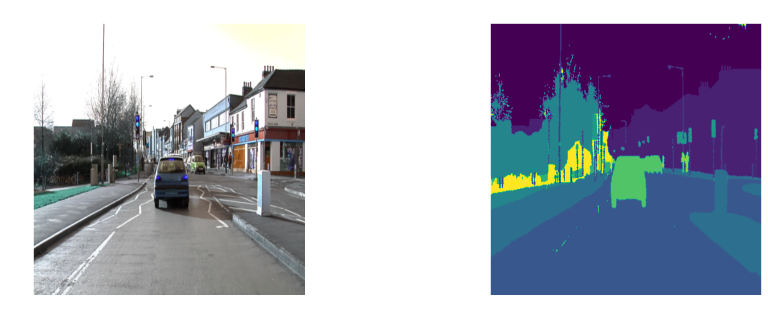

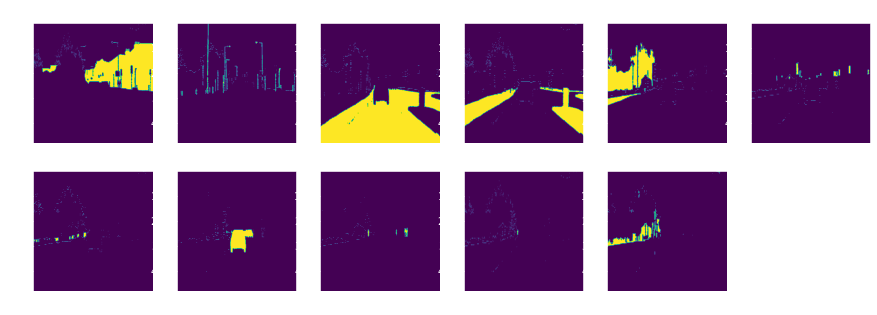

In [23]:
#Plot one hot encoding
fig = plt.figure(figsize = (15,5))
fig2 = plt.figure(figsize = (15,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title("original image of train images")
ax1.imshow(x_train[10], cmap='gray')

ax2.set_title("original image of train annotations")
ax2.imshow(y_train[10])

for index in range(1, 12):
    ax = fig2.add_subplot(2,6, index)
    ax.set_title("one hot {}".format(index))
    ax.imshow(label_train[10][:,:,index])

plt.show()

In [24]:
height = x_train.shape[1]
width = x_train.shape[2]
channel = x_train.shape[3]

In [25]:
#Unet model

inputs = tf.keras.Input((width,height,channel))

conv1 = Conv2D(64, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(inputs)
conv1 = Conv2D(64, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv1)
pool1 = MaxPooling2D(2,2)(conv1)

conv2 = Conv2D(128, 3, activation= 'relu', kernel_initializer='he_normal', padding = 'same')(pool1)
conv2 = Conv2D(128, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(conv2)
pool2 = MaxPooling2D(2,2)(conv2)

conv3 = Conv2D(256, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(pool2)
conv3 = Conv2D(256, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv3)
pool3 = MaxPooling2D(2,2)(conv3)

conv4 = Conv2D(512, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(pool3)
conv4 = Conv2D(512, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv4)
# dropout4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(2,2)(conv4)


conv5 = Conv2D(1024, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(pool4)
conv5 = Conv2D(1024, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(conv5)
dropout5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(dropout5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', kernel_initializer='he_normal', padding = 'same')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
,
up9 = Conv2D(64, 2, activation = 'relu', kernel_initializer='he_normal', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(conv9)

conv9 = Conv2D(64, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(conv9)
conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

model = tf.keras.Model(inputs,conv10)
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 480, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 480, 480, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

 conv2d_17 (Conv2D)             (None, 240, 240, 12  295040      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 240, 240, 12  147584      ['conv2d_17[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 480, 480, 12  0          ['conv2d_18[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 480, 480, 64  32832       ['up_sampling2d_3[0][0]']        
          

In [ ]:
history = model.fit(
    x_train, 
    label_train, 
    validation_data=(x_test, label_test), 
    epochs=60, 
    batch_size=24)

In [ ]:
model.save('semantic_model2.h5')

In [ ]:
y_pred=load.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)   
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

In [ ]:
val = 0
total = 0
res = []

for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    
    for x in range(n_classes):
        if x != i:
            sum2 = values[x, i] + sum2  
        else:
            continue
    total = sum1 + sum2
    res.append(val/total)
    print("IoU class {}: {}".format(i,res[i]))

In [ ]:
#plot IOU
index = []
for i in range (len(res)):
    index.append(i)
    
plt.title("IoU for each class")
plt.bar(index, res)

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)


plt.show()

In [ ]:
#Plot Prediction Image

num = random.randint(0,len(x_test))
# num = 3

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Original Test Image')
plt.imshow(x_test[num])

plt.subplot(232)
plt.title('Label Test Image')
plt.imshow(y_test[num].squeeze(), cmap ='jet')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_argmax[num], cmap='jet')


plt.show()